# Multi-Momentum Range PID Analysis
## Particle Identification with Optuna Optimization & Model Caching

This notebook analyses Particle Identification (PID) performance across 4 momentum ranges:
- **Full Spectrum**: All data combined
- **Low Momentum**: 0.1-1 GeV/c
- **Mid Momentum**: 1-3 GeV/c
- **High Momentum**: 3+ GeV/c

Key features:
- Automatic hyperparameter optimization using Optuna
- Model caching - models are saved and loaded automatically
- Multi-range comparison with interactive dashboard
- PID efficiency and purity metrics


## SECTION 1: Environment Setup
### Install Dependencies & Initialise Libraries

This section installs all required Python packages and imports the necessary libraries for data processing, machine learning, and visualization.

In [1]:
!pip install hipe4ml optuna pandas numpy matplotlib seaborn scikit-learn xgboost ipywidgets -q
!pip install scikit-learn>=1.6 -q
print("✓ Dependencies installed")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 392.4/392.4 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.0/908.0 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 655.9/655.9 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.
✓ Dependencies installed


### Import Libraries
Load all required Python modules for data handling, machine learning, optimisation, and visualisation.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
import pickle
import os

from hipe4ml.model_handler import ModelHandler
from hipe4ml import plot_utils

import xgboost as xgb
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

from google.colab import drive
import ipywidgets as widgets
from IPython.display import display, clear_output

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## SECTION 2: Configuration
### Define Momentum Ranges, Particles & Storage Paths

This section sets up:
- **Momentum ranges**: 4 ranges from full spectrum to high momentum
- **Particle types**: 5 species (Pion, Kaon, Proton, Electron, Deuteron)
- **Storage directories**: Where trained models and Optuna studies are saved/loaded
- **Google Drive mounting**: For persistent storage across sessions

In [3]:
print("="*80)
print("SECTION 2: CONFIGURATION")
print("="*80)

# Mount Google Drive for persistent storage
drive.mount('/content/drive')

# Define momentum ranges for analysis
# Each range has: name, momentum bounds (GeV/c), and color for plots
MOMENTUM_RANGES = {
    'full': {'name': 'All Data (full spectrum)', 'min': 0.0,  'max': 999, 'color': '#9333EA'},
    'low':  {'name': '0.1-1 GeV/c',           'min': 0.1, 'max': 1.0,  'color': '#3B82F6'},
    'mid':  {'name': '1-3 GeV/c',            'min': 1.0, 'max': 3.0,  'color': '#F59E0B'},
    'high': {'name': '3+ GeV/c',             'min': 3.0, 'max': 999,  'color': '#22C55E'}
}

# Particle names for PID (indices 0-4)
PARTICLE_NAMES = ['Pion', 'Kaon', 'Proton', 'Electron']

# Storage directories in Google Drive
MODEL_SAVE_DIR = '/content/drive/MyDrive/PID_Models/'
OPTUNA_SAVE_DIR = '/content/drive/MyDrive/PID_Optuna_Studies/'

# Create directories if they don't exist
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(OPTUNA_SAVE_DIR, exist_ok=True)

print("✓ Configuration loaded")
print(f"  Momentum ranges: {list(MOMENTUM_RANGES.keys())}")
print(f"  Particles: {PARTICLE_NAMES}")
print(f"  Model storage: {MODEL_SAVE_DIR}")
print(f"  Optuna storage: {OPTUNA_SAVE_DIR}")

SECTION 2: CONFIGURATION
Mounted at /content/drive
✓ Configuration loaded
  Momentum ranges: ['full', 'low', 'mid', 'high']
  Particles: ['Pion', 'Kaon', 'Proton', 'Electron']
  Model storage: /content/drive/MyDrive/PID_Models/
  Optuna storage: /content/drive/MyDrive/PID_Optuna_Studies/


### Define Save/Load Functions for Models & Optuna Studies

These functions handle:
- **Saving trained models**: Store XGBoost models with metadata to Google Drive
- **Loading trained models**: Retrieve saved models to avoid retraining
- **Saving Optuna studies**: Store optimisation results
- **Loading Optuna studies**: Retrieve hyperparameter optimisation results
- **Checking saved artifacts**: List which models/studies exist

In [4]:
def save_trained_model(range_key, model_info, dataset_info):
    """Save trained XGBoost model with metadata to Google Drive."""
    save_path = os.path.join(MODEL_SAVE_DIR, f'model_{range_key}.pkl')
    save_data = {
        'model': model_info['model_handler'].model,
        'features': available_features,
        'config': model_info['config'],
        'train_acc': model_info['train_acc'],
        'test_acc': model_info['test_acc'],
        'n_train': dataset_info['n_train'],
        'n_test': dataset_info['n_test']
    }
    with open(save_path, 'wb') as f:
        pickle.dump(save_data, f)
    print(f"Saved model: {save_path}")

def load_trained_model(range_key):
    """Load previously trained model from Google Drive."""
    load_path = os.path.join(MODEL_SAVE_DIR, f'model_{range_key}.pkl')
    if not os.path.exists(load_path):
        return None
    with open(load_path, 'rb') as f:
        save_data = pickle.load(f)
    model_hdl = ModelHandler(save_data['model'], save_data['features'])
    model_hdl.model = save_data['model']
    return {
        'model_handler': model_hdl,
        'config': save_data['config'],
        'train_acc': save_data['train_acc'],
        'test_acc': save_data['test_acc'],
        'loaded': True
    }

def save_optuna_study(range_key, study):
    """Save Optuna optimisation study to Google Drive."""
    save_path = os.path.join(OPTUNA_SAVE_DIR, f'optuna_study_{range_key}.pkl')
    with open(save_path, 'wb') as f:
        pickle.dump(study, f)
    print(f"Saved Optuna study: {save_path}")

def load_optuna_study(range_key):
    """Load previously saved Optuna study from Google Drive."""
    load_path = os.path.join(OPTUNA_SAVE_DIR, f'optuna_study_{range_key}.pkl')
    if not os.path.exists(load_path):
        return None
    with open(load_path, 'rb') as f:
        study = pickle.load(f)
    return study

def check_saved_models():
    """List all saved models in Google Drive."""
    saved_models = []
    for range_key in MOMENTUM_RANGES.keys():
        model_path = os.path.join(MODEL_SAVE_DIR, f'model_{range_key}.pkl')
        if os.path.exists(model_path):
            saved_models.append(range_key)
    return saved_models

def check_saved_studies():
    """List all saved Optuna studies in Google Drive."""
    saved_studies = []
    for range_key in MOMENTUM_RANGES.keys():
        study_path = os.path.join(OPTUNA_SAVE_DIR, f'optuna_study_{range_key}.pkl')
        if os.path.exists(study_path):
            saved_studies.append(range_key)
    return saved_studies

print("✓ Save/Load functions defined")

✓ Save/Load functions defined


## SECTION 3: Data Loading & Cleaning
### Load CSV Data & Perform Quality Checks

This section:
- **Loads the CSV file** in chunks to handle large datasets efficiently
- **Handles missing values**: Replaces -999 with NaN and fills appropriately
- **Manages detector data**: TOF (Time-of-Flight) and TPC (Time Projection Chamber) signals
- **Filters invalid data**: Removes tracks with missing momentum or PID info

In [6]:
print("\n" + "="*80)
print("SECTION 3: DATA LOADING")
print("="*80)

# Load CSV in chunks to handle large files
csv_file_path = '/content/drive/MyDrive/pid_features_large.csv'
print(f"Loading data from: {csv_file_path}")

df_iter = pd.read_csv(csv_file_path, dtype='float32', chunksize=500_000, low_memory=False)
df = pd.concat(df_iter, ignore_index=True)

print(f"✓ Loaded dataset: {df.shape[0]:,} tracks × {df.shape[1]} features")


SECTION 3: DATA LOADING
Loading data from: /content/drive/MyDrive/pid_features_large.csv
✓ Loaded dataset: 4,729,393 tracks × 37 features


### Clean Data & Handle Missing Values

Preprocessing steps:
- Replace sentinel values (-999) with NaN
- Fill missing TOF/TPC values with 0 (no signal = no detector hit)
- Create binary flags for detector availability
- Drop incomplete records

In [7]:
print("\n" + "="*80)
print("SECTION 3B: DATA CLEANING & FEATURE ENGINEERING")
print("="*80)

print("\nStep 1: Handling missing values...")
# Replace sentinel values
df.replace(-999, np.nan, inplace=True)

# Identify TOF and TPC columns
tof_features = [col for col in df.columns if 'tof' in col.lower()]
tpc_features = [col for col in df.columns if 'tpc' in col.lower()]

print(f"  Found {len(tof_features)} TOF features and {len(tpc_features)} TPC features")

# Fill missing detector signals
df[tof_features] = df[tof_features].fillna(0)
df[tpc_features] = df[tpc_features].fillna(0)

# Create binary flags for detector availability
df['has_tof'] = (df[tof_features].abs().sum(axis=1) > 0).astype(int)
df['has_tpc'] = (df[tpc_features].abs().sum(axis=1) > 0).astype(int)

print(f"  Tracks with TOF: {df['has_tof'].sum():,}")
print(f"  Tracks with TPC: {df['has_tpc'].sum():,}")

# Remove incomplete records
print("\nStep 2: Removing incomplete records...")
initial_count = len(df)
df.dropna(subset=['pt', 'eta', 'mc_pdg'], inplace=True)
dropped = initial_count - len(df)
print(f"  Initial tracks: {initial_count:,}")
print(f"  Dropped: {dropped:,} (incomplete records)")
print(f"  Final: {len(df):,} clean tracks")


SECTION 3B: DATA CLEANING & FEATURE ENGINEERING

Step 1: Handling missing values...
  Found 7 TOF features and 8 TPC features
  Tracks with TOF: 371,799
  Tracks with TPC: 4,294,217

Step 2: Removing incomplete records...
  Initial tracks: 4,729,393
  Dropped: 1 (incomplete records)
  Final: 4,729,392 clean tracks


### Map PDG Codes to Particle Species & Extract Features

This step:
- **Converts PDG codes** to particle indices (0=Pion, 1=Kaon, 2=Proton, 3=Electron)
- **Applies log scaling** to momentum variables
- **Selects features** for machine learning model

In [8]:
print("\n" + "="*80)
print("SECTION 4: PDG MAPPING & FEATURE EXTRACTION")
print("="*80)

def pdg_to_species(pdg):
    """Convert PDG code to particle species index."""
    ap = abs(int(pdg))
    if ap == 211:          return 0  # pion (π)
    elif ap == 321:        return 1  # kaon (K)
    elif ap == 2212:       return 2  # proton (p)
    elif ap == 11:         return 3  # electron (e)
    # elif ap == 1000010020: return 4  # deuteron (d)
    else: return -1  # unknown

print("\nStep 1: Mapping PDG codes to particle species...")
df['particle_species'] = df['mc_pdg'].apply(pdg_to_species)
df = df[df['particle_species'] >= 0].reset_index(drop=True)

print("Particle species distribution:")
dist = df['particle_species'].value_counts().sort_index()
for idx, count in dist.items():
    print(f"  {PARTICLE_NAMES[idx]:12s} (PDG {idx:d}): {count:8d} tracks")

print("\nStep 2: Feature engineering and transformation...")
# Apply log transformation to momentum-related features
for feature in ['pt', 'p', 'tpc_signal', 'tof_beta']:
    if feature in df.columns:
        df[feature] = np.log1p(df[feature].abs())
        print(f"  Applied log transform to: {feature}")

# Select features for ML model
training_features = [
    'pt', 'eta', 'phi',
    'tpc_signal', 'tpc_nsigma_pi', 'tpc_nsigma_ka', 'tpc_nsigma_pr', 'tpc_nsigma_el',
    'tof_beta', 'tof_nsigma_pi', 'tof_nsigma_ka', 'tof_nsigma_pr', 'tof_nsigma_el',
    'bayes_prob_pi', 'bayes_prob_ka', 'bayes_prob_pr', 'bayes_prob_el',
    'dca_xy', 'dca_z', 'has_tpc', 'has_tof'
]
available_features = [f for f in training_features if f in df.columns]
print(f"\n✓ Selected {len(available_features)} features for ML model")


SECTION 4: PDG MAPPING & FEATURE EXTRACTION

Step 1: Mapping PDG codes to particle species...
Particle species distribution:
  Pion         (PDG 0):  2879564 tracks
  Kaon         (PDG 1):   197625 tracks
  Proton       (PDG 2):   517809 tracks
  Electron     (PDG 3):   568956 tracks

Step 2: Feature engineering and transformation...
  Applied log transform to: pt
  Applied log transform to: p
  Applied log transform to: tpc_signal
  Applied log transform to: tof_beta

✓ Selected 21 features for ML model


## SECTION 5: Data Splitting by Momentum Ranges
### Split Dataset into 4 Momentum-Range Subsets

This section:
- **Filters data** for each momentum range (0.1-1, 1-3, 3+ GeV/c, and full)
- **Standardises features** using StandardScaler
- **Splits train/test** (70% train, 30% test) with stratification
- **Prepares datasets** for independent model training

In [9]:
print("\n" + "="*80)
print("SECTION 5: MOMENTUM RANGE SPLITTING")
print("="*80)
print("\nSplitting dataset into 4 momentum ranges...\n")

momentum_datasets = {}

for range_key, range_config in MOMENTUM_RANGES.items():
    print(f"{range_config['name']}")
    print(f"   Momentum range: {range_config['min']:.2f} - {range_config['max']:.0f} GeV/c")

    # Filter by momentum
    df_range = df[
        (df['pt'] >= range_config['min']) &
        (df['pt'] < range_config['max'])
    ].copy()

    print(f"Total tracks: {len(df_range):,}")

    if len(df_range) == 0:
        print(f"No data in this range, skipping...\n")
        continue

    # Prepare features and target
    X = df_range[available_features].astype('float32')
    y = df_range['particle_species']

    # Check minimum samples per class
    if y.value_counts().min() < 10:
        print(f"Insufficient samples for some classes, skipping...\n")
        continue

    # Standardize features (0 mean, 1 std)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=available_features).astype('float32')

    # Train/test split with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, random_state=42, stratify=y
    )
    X_train, X_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True)
    y_train, y_test = pd.Series(y_train.values), pd.Series(y_test.values)

    momentum_datasets[range_key] = {
        'config': range_config,
        'X_train': X_train, 'X_test': X_test,
        'y_train': y_train, 'y_test': y_test,
        'n_train': len(X_train), 'n_test': len(X_test)
    }

    print(f"   Train set: {len(X_train):,} tracks (70%)")
    print(f"   Test set:  {len(X_test):,} tracks (30%)")
    print(f"   ✓ Ready for training\n")

print(f"✓ Successfully prepared {len(momentum_datasets)} datasets")


SECTION 5: MOMENTUM RANGE SPLITTING

Splitting dataset into 4 momentum ranges...

All Data (full spectrum)
   Momentum range: 0.00 - 999 GeV/c
Total tracks: 4,163,954
   Train set: 2,914,767 tracks (70%)
   Test set:  1,249,187 tracks (30%)
   ✓ Ready for training

0.1-1 GeV/c
   Momentum range: 0.10 - 1 GeV/c
Total tracks: 3,956,919
   Train set: 2,769,843 tracks (70%)
   Test set:  1,187,076 tracks (30%)
   ✓ Ready for training

1-3 GeV/c
   Momentum range: 1.00 - 3 GeV/c
Total tracks: 128,035
   Train set: 89,624 tracks (70%)
   Test set:  38,411 tracks (30%)
   ✓ Ready for training

3+ GeV/c
   Momentum range: 3.00 - 999 GeV/c
Total tracks: 157
   Train set: 109 tracks (70%)
   Test set:  48 tracks (30%)
   ✓ Ready for training

✓ Successfully prepared 4 datasets


## SECTION 6: Hyperparameter Optimisation with Optuna
### Automatically Find Optimal XGBoost Hyperparameters

This section:
- **Checks for saved Optuna studies** (loads if available)
- **Runs 20 trials** using Optuna's TPE sampler to find best hyperparameters
- **Optimizes for ROC-AUC** (One-vs-Rest, weighted average)
- **Saves studies** for future use

In [12]:
print("\n" + "="*80)
print("SECTION 6: OPTUNA HYPERPARAMETER OPTIMISATION")
print("="*80)

optuna_studies = {}
FORCE_REOPTIMIZE = False  # Set to True to force re-optimisation

saved_studies = check_saved_studies()
if saved_studies:
    print(f"\n Found {len(saved_studies)} saved Optuna studies: {saved_studies}")
    print("   Will load saved studies and skip optimisation.\n")

for range_key, dataset in momentum_datasets.items():
    config = dataset['config']
    print(f"\n{'='*70}")
    print(f"Processing: {config['name']}")
    print(f"{'='*70}")

    # Try to load existing study
    if os.path.exists(os.path.join(OPTUNA_SAVE_DIR, f'optuna_study_{range_key}.pkl')) and not FORCE_REOPTIMIZE:
        print(f"Loading saved Optuna study...")
        study = load_optuna_study(range_key)
        optuna_studies[range_key] = study
        print(f"   ✓ Study loaded")
        print(f"   ✓ Best ROC-AUC: {study.best_value:.4f}")
        print(f"   ✓ Best parameters: {study.best_params}")
        continue

    # Run new optimisation
    print(f"Running Optuna optimisation (20 trials)...")
    print(f"This may take 10-20 minutes depending on data size.")

    # Sample training data for faster optimisation
    X_train_optuna = dataset['X_train'].sample(
        min(300_000, len(dataset['X_train'])), random_state=42
    )
    y_train_optuna = dataset['y_train'].loc[X_train_optuna.index]

    def objective(trial):
        """Objective function for Optuna to maximise ROC-AUC."""
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 200, 800, step=100),
            'max_depth': trial.suggest_int('max_depth', 4, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0.0, 1.0)
        }
        model = xgb.XGBClassifier(**params, random_state=42, n_jobs=-1, tree_method='hist')
        model.fit(X_train_optuna, y_train_optuna)
        y_pred = model.predict_proba(dataset['X_test'])
        return roc_auc_score(dataset['y_test'], y_pred, multi_class='ovo', average='weighted')

    # Create and run study
    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
    study.optimize(objective, n_trials=20, show_progress_bar=True)
    optuna_studies[range_key] = study

    # Save the study
    save_optuna_study(range_key, study)

    print(f"   ✓ Best ROC-AUC: {study.best_value:.4f}")
    print(f"   ✓ Best parameters saved")

print("\n" + "="*80)
print(f"✓ Optuna optimisation complete for {len(optuna_studies)} ranges")
print("="*80)


SECTION 6: OPTUNA HYPERPARAMETER OPTIMISATION

Processing: All Data (full spectrum)
Running Optuna optimisation (20 trials)...
This may take 10-20 minutes depending on data size.


[I 2025-11-02 08:23:27,426] A new study created in memory with name: no-name-f49da1ae-448c-4bdf-b6ea-2ed5cc41ea32


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-11-02 08:28:10,028] Trial 0 finished with value: 0.9351507627121043 and parameters: {'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.15599452033620265}. Best is trial 0 with value: 0.9351507627121043.
[I 2025-11-02 08:29:59,244] Trial 1 finished with value: 0.9382259318347423 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.07725378389307355, 'subsample': 0.8832290311184181, 'colsample_bytree': 0.608233797718321, 'gamma': 0.9699098521619943}. Best is trial 1 with value: 0.9382259318347423.
[I 2025-11-02 08:33:22,431] Trial 2 finished with value: 0.9360387995248902 and parameters: {'n_estimators': 700, 'max_depth': 5, 'learning_rate': 0.01855998084649059, 'subsample': 0.6733618039413735, 'colsample_bytree': 0.7216968971838151, 'gamma': 0.5247564316322378}. Best is trial 1 with value: 0.9382259318347423.
[I 2025-11-02 08:36:08,328] Trial 3 finish

[I 2025-11-02 09:35:20,541] A new study created in memory with name: no-name-bbb2a346-629f-4029-b692-47465a595d65


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-11-02 09:39:32,548] Trial 0 finished with value: 0.9377637386888814 and parameters: {'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.15599452033620265}. Best is trial 0 with value: 0.9377637386888814.
[I 2025-11-02 09:41:11,302] Trial 1 finished with value: 0.9408143930127723 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.07725378389307355, 'subsample': 0.8832290311184181, 'colsample_bytree': 0.608233797718321, 'gamma': 0.9699098521619943}. Best is trial 1 with value: 0.9408143930127723.
[I 2025-11-02 09:44:22,468] Trial 2 finished with value: 0.9389195681099682 and parameters: {'n_estimators': 700, 'max_depth': 5, 'learning_rate': 0.01855998084649059, 'subsample': 0.6733618039413735, 'colsample_bytree': 0.7216968971838151, 'gamma': 0.5247564316322378}. Best is trial 1 with value: 0.9408143930127723.
[I 2025-11-02 09:47:03,845] Trial 3 finish

[I 2025-11-02 10:44:29,215] A new study created in memory with name: no-name-081524e4-116e-486a-9803-179b9e3d97a6


[I 2025-11-02 10:44:29,146] Trial 19 finished with value: 0.9374153801484457 and parameters: {'n_estimators': 400, 'max_depth': 8, 'learning_rate': 0.010135820288878864, 'subsample': 0.9918585998724916, 'colsample_bytree': 0.7911302960155628, 'gamma': 0.8117701352693814}. Best is trial 4 with value: 0.9409822383437692.
Saved Optuna study: /content/drive/MyDrive/PID_Optuna_Studies/optuna_study_low.pkl
   ✓ Best ROC-AUC: 0.9410
   ✓ Best parameters saved

Processing: 1-3 GeV/c
Running Optuna optimisation (20 trials)...
This may take 10-20 minutes depending on data size.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-11-02 10:45:26,540] Trial 0 finished with value: 0.8307125704681838 and parameters: {'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.15599452033620265}. Best is trial 0 with value: 0.8307125704681838.
[I 2025-11-02 10:45:45,062] Trial 1 finished with value: 0.8420866767750392 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.07725378389307355, 'subsample': 0.8832290311184181, 'colsample_bytree': 0.608233797718321, 'gamma': 0.9699098521619943}. Best is trial 1 with value: 0.8420866767750392.
[I 2025-11-02 10:46:27,429] Trial 2 finished with value: 0.8429249383300063 and parameters: {'n_estimators': 700, 'max_depth': 5, 'learning_rate': 0.01855998084649059, 'subsample': 0.6733618039413735, 'colsample_bytree': 0.7216968971838151, 'gamma': 0.5247564316322378}. Best is trial 2 with value: 0.8429249383300063.
[I 2025-11-02 10:47:04,319] Trial 3 finish

[I 2025-11-02 10:58:18,306] A new study created in memory with name: no-name-001c59b9-c6ae-4e8a-b15c-c71c2e7c30e4


[I 2025-11-02 10:58:18,279] Trial 19 finished with value: 0.8429815813367424 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05463189733276921, 'subsample': 0.9344291259107609, 'colsample_bytree': 0.8250051428101366, 'gamma': 0.7836437870888336}. Best is trial 19 with value: 0.8429815813367424.
Saved Optuna study: /content/drive/MyDrive/PID_Optuna_Studies/optuna_study_mid.pkl
   ✓ Best ROC-AUC: 0.8430
   ✓ Best parameters saved

Processing: 3+ GeV/c
Running Optuna optimisation (20 trials)...
This may take 10-20 minutes depending on data size.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-11-02 10:58:18,573] Trial 0 finished with value: 0.667222702252944 and parameters: {'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.15599452033620265}. Best is trial 0 with value: 0.667222702252944.
[I 2025-11-02 10:58:18,714] Trial 1 finished with value: 0.6658786162314387 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.07725378389307355, 'subsample': 0.8832290311184181, 'colsample_bytree': 0.608233797718321, 'gamma': 0.9699098521619943}. Best is trial 0 with value: 0.667222702252944.
[I 2025-11-02 10:58:19,186] Trial 2 finished with value: 0.6804635496671786 and parameters: {'n_estimators': 700, 'max_depth': 5, 'learning_rate': 0.01855998084649059, 'subsample': 0.6733618039413735, 'colsample_bytree': 0.7216968971838151, 'gamma': 0.5247564316322378}. Best is trial 2 with value: 0.6804635496671786.
[I 2025-11-02 10:58:19,473] Trial 3 finished 

### ALTERNATIVE: Use Fixed Hyperparameters (Uncomment to Use)

**Advantages of fixed params:**
- Much faster (~5 mins vs 2-3 hours)
- Still good performance

**Disadvantages:**
- Less optimal than Optuna-tuned

To use fixed parameters:
1. Comment out the Optuna cell above (SECTION 6)
2. Uncomment the cell below


In [ ]:
# # ALTERNATIVE: USE FIXED HYPERPARAMETERS (SKIP OPTUNA)
# print("\n" + "="*80)
# print("SECTION 6 ALTERNATIVE: USING FIXED HYPERPARAMETERS")
# print("="*80)
#
# print("\nUsing pre-tuned hyperparameters (skipping Optuna optimization)...")
#
# PRESET_PARAMS = {
#     'full': {
#         'n_estimators': 500,
#         'max_depth': 6,
#         'learning_rate': 0.1,
#         'subsample': 0.8,
#         'colsample_bytree': 0.8,
#         'gamma': 0.5
#     },
#     'low': {
#         'n_estimators': 400,
#         'max_depth': 5,
#         'learning_rate': 0.15,
#         'subsample': 0.85,
#         'colsample_bytree': 0.85,
#         'gamma': 0.3
#     },
#     'mid': {
#         'n_estimators': 450,
#         'max_depth': 6,
#         'learning_rate': 0.12,
#         'subsample': 0.8,
#         'colsample_bytree': 0.8,
#         'gamma': 0.4
#     },
#     'high': {
#         'n_estimators': 400,
#         'max_depth': 5,
#         'learning_rate': 0.15,
#         'subsample': 0.82,
#         'colsample_bytree': 0.82,
#         'gamma': 0.35
#     }
# }
#
# optuna_studies = {}
# for range_key, dataset in momentum_datasets.items():
#     config = dataset['config']
#     print(f"\n✓ Using preset parameters for {config['name']}")
#     optuna_studies[range_key] = type('Study', (), {'best_params': PRESET_PARAMS[range_key]})()
#
# print("\n✓ Hyperparameters loaded (Optuna optimization skipped)")


## SECTION 7: Model Training with Automatic Saving/Loading
### Train XGBoost Models for Each Momentum Range

This section:
- **Checks for saved models** (loads if available - saves time!)
- **Trains new models** using Optuna-optimised hyperparameters
- **Generates predictions** on test set
- **Saves models** to Google Drive for future use
- **Reports accuracies** for each range

In [13]:
print("\n" + "="*80)
print("SECTION 7: MODEL TRAINING (WITH AUTO-SAVE & LOAD)")
print("="*80)

# Check existing models
saved_models = check_saved_models()
if saved_models:
    print(f"\n Found {len(saved_models)} saved models: {saved_models}")
    print("   Will load these models and skip training.\n")

trained_models = {}
FORCE_RETRAIN = False  # Set to True to force re-training

for range_key, dataset in momentum_datasets.items():
    config = dataset['config']
    print(f"\n{'='*70}")
    print(f"Processing: {config['name']}")
    print(f"{'='*70}")

    # Try to load existing model
    model_path = os.path.join(MODEL_SAVE_DIR, f'model_{range_key}.pkl')

    if os.path.exists(model_path) and not FORCE_RETRAIN:
        print(f"📂 Loading saved model...")
        loaded = load_trained_model(range_key)

        if loaded:
            # Generate predictions with loaded model
            y_pred = loaded['model_handler'].model.predict_proba(dataset['X_test'])

            trained_models[range_key] = {
                'model_handler': loaded['model_handler'],
                'y_pred_proba': y_pred,
                'train_acc': loaded['train_acc'],
                'test_acc': loaded['test_acc'],
                'config': config
            }

            print(f"✓ Model loaded successfully!")
            print(f"   Training accuracy: {loaded['train_acc']:.4f}")
            print(f"   Test accuracy:     {loaded['test_acc']:.4f}")
            continue

    # Train new model if not found
    print(f"Training new XGBoost model...")

    # Get optimized hyperparameters from Optuna
    best_params = optuna_studies[range_key].best_params

    # Create XGBoost classifier with optimized parameters
    model = xgb.XGBClassifier(
        **best_params,
        random_state=42,
        n_jobs=-1,
        tree_method='hist'  # Fast histogram-based tree building
    )

    print(f"   Training on {len(dataset['X_train']):,} samples...")
    model.fit(dataset['X_train'], dataset['y_train'])

    # Generate predictions
    y_pred = model.predict_proba(dataset['X_test'])
    train_acc = model.score(dataset['X_train'], dataset['y_train'])
    test_acc = model.score(dataset['X_test'], dataset['y_test'])

    # Wrap in hipe4ml ModelHandler for compatibility
    model_hdl = ModelHandler(model, available_features)
    model_hdl.model = model

    # Store results
    trained_models[range_key] = {
        'model_handler': model_hdl,
        'y_pred_proba': y_pred,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'config': config
    }

    print(f"   ✓ Training accuracy: {train_acc:.4f}")
    print(f"   ✓ Test accuracy:     {test_acc:.4f}")

    # Save the trained model
    save_trained_model(range_key, trained_models[range_key], dataset)

print("\n" + "="*80)
print(f"✓ Successfully prepared {len(trained_models)} trained models")
print("="*80)


SECTION 7: MODEL TRAINING (WITH AUTO-SAVE & LOAD)

Processing: All Data (full spectrum)
Training new XGBoost model...
   Training on 2,914,767 samples...
   ✓ Training accuracy: 0.8705
   ✓ Test accuracy:     0.8675
Saved model: /content/drive/MyDrive/PID_Models/model_full.pkl

Processing: 0.1-1 GeV/c
Training new XGBoost model...
   Training on 2,769,843 samples...
   ✓ Training accuracy: 0.8769
   ✓ Test accuracy:     0.8741
Saved model: /content/drive/MyDrive/PID_Models/model_low.pkl

Processing: 1-3 GeV/c
Training new XGBoost model...
   Training on 89,624 samples...
   ✓ Training accuracy: 0.7554
   ✓ Test accuracy:     0.7470
Saved model: /content/drive/MyDrive/PID_Models/model_mid.pkl

Processing: 3+ GeV/c
Training new XGBoost model...
   Training on 109 samples...
   ✓ Training accuracy: 0.8899
   ✓ Test accuracy:     0.6667
Saved model: /content/drive/MyDrive/PID_Models/model_high.pkl

✓ Successfully prepared 4 trained models


## SECTION 8: Model Visualisation & Analysis
### Generate ROC Curves, Confusion Matrices, and Feature Importance

For each momentum range, this section creates:
- **BDT Output Distributions**: Shows model confidence scores
- **ROC Curves**: Performance for each particle species
- **Confusion Matrices**: Classification accuracy breakdown
- **Feature Importance**: Which features matter most


SECTION 8: MODEL VISUALISATION & ANALYSIS

VISUALISATIONS: All Data (full spectrum)

  Generating BDT output distributions...


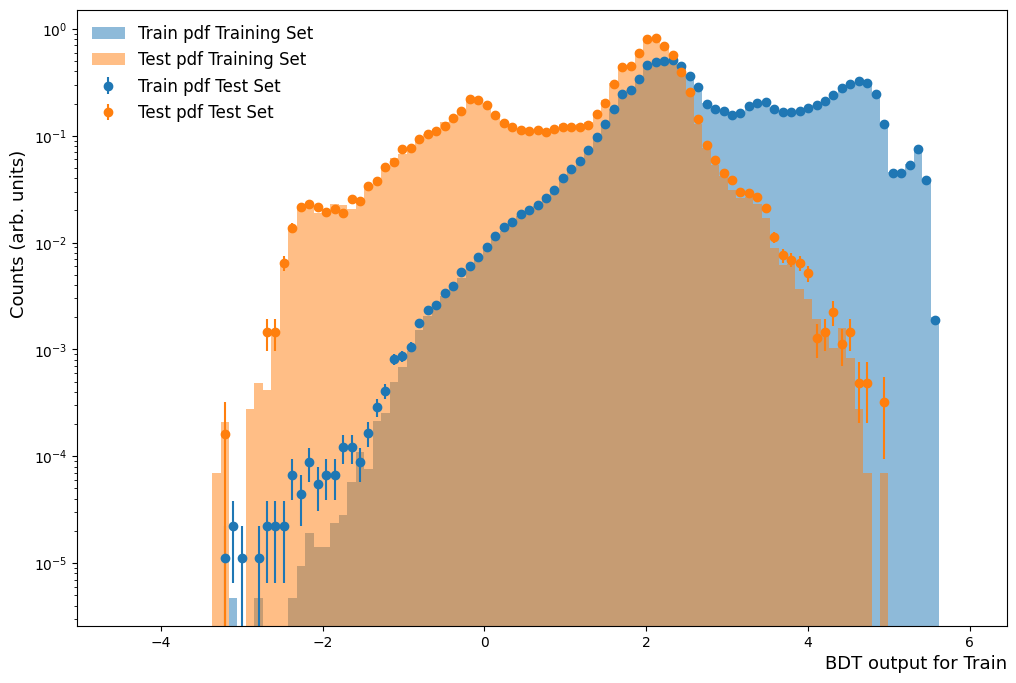

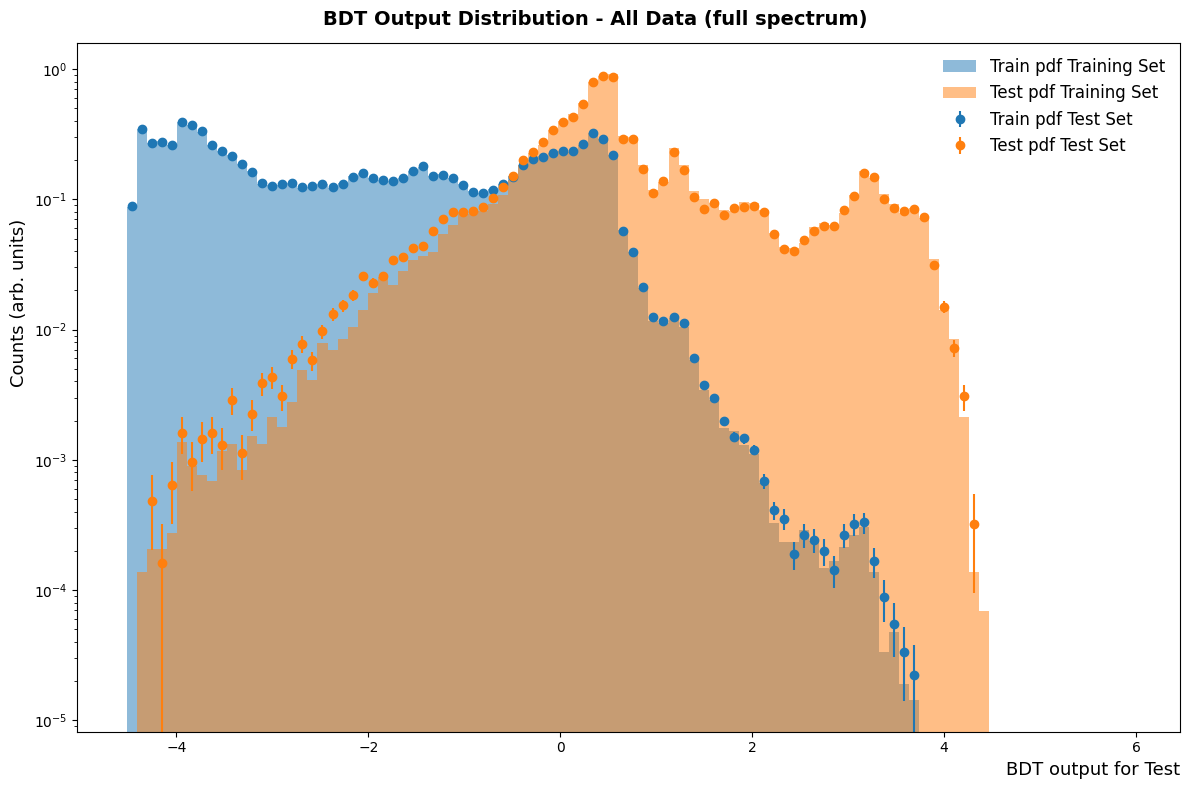

  ✓ BDT output plot created

  Generating ROC curves...


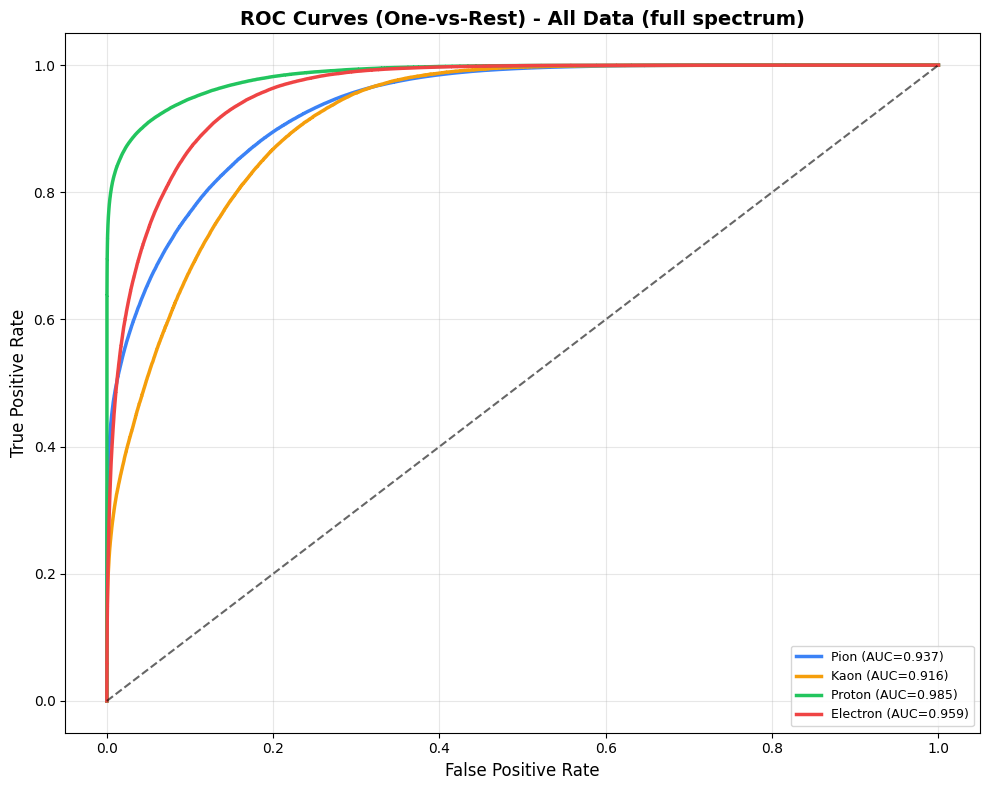

  ✓ ROC curves created

  Generating confusion matrix...


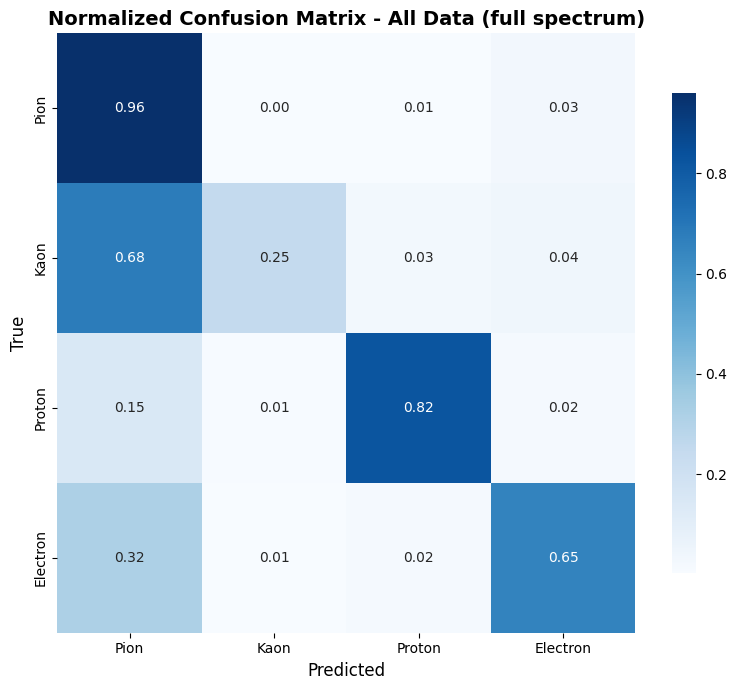

  ✓ Confusion matrix created

  Generating feature importance...


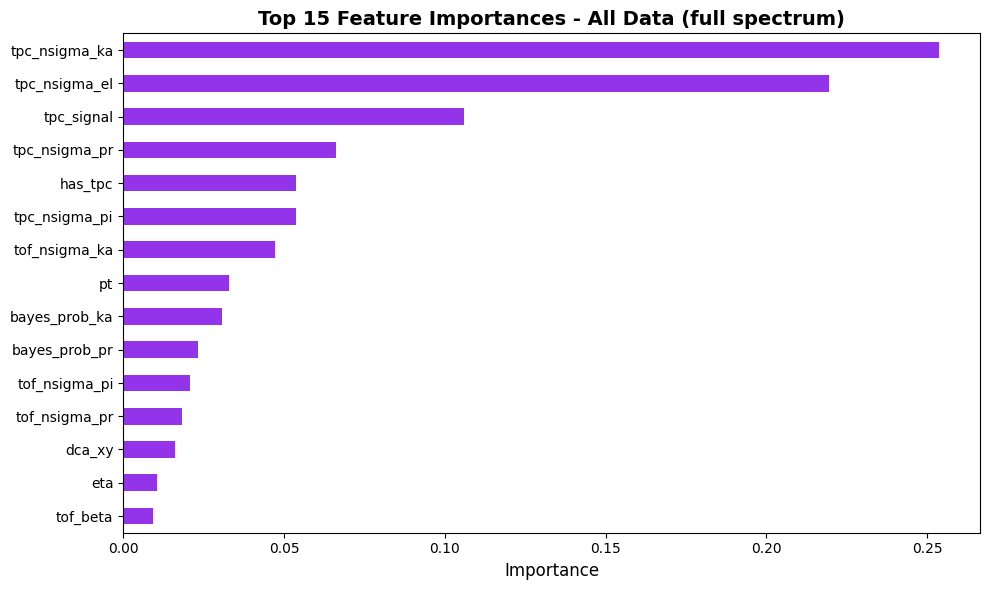

  ✓ Feature importance plot created

VISUALISATIONS: 0.1-1 GeV/c

  Generating BDT output distributions...


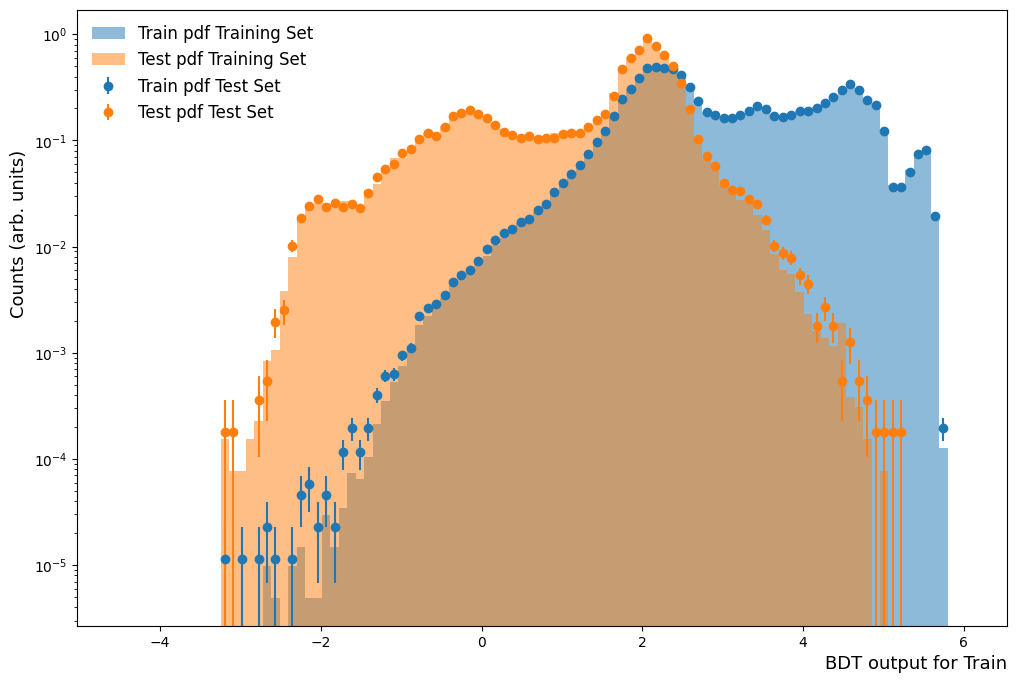

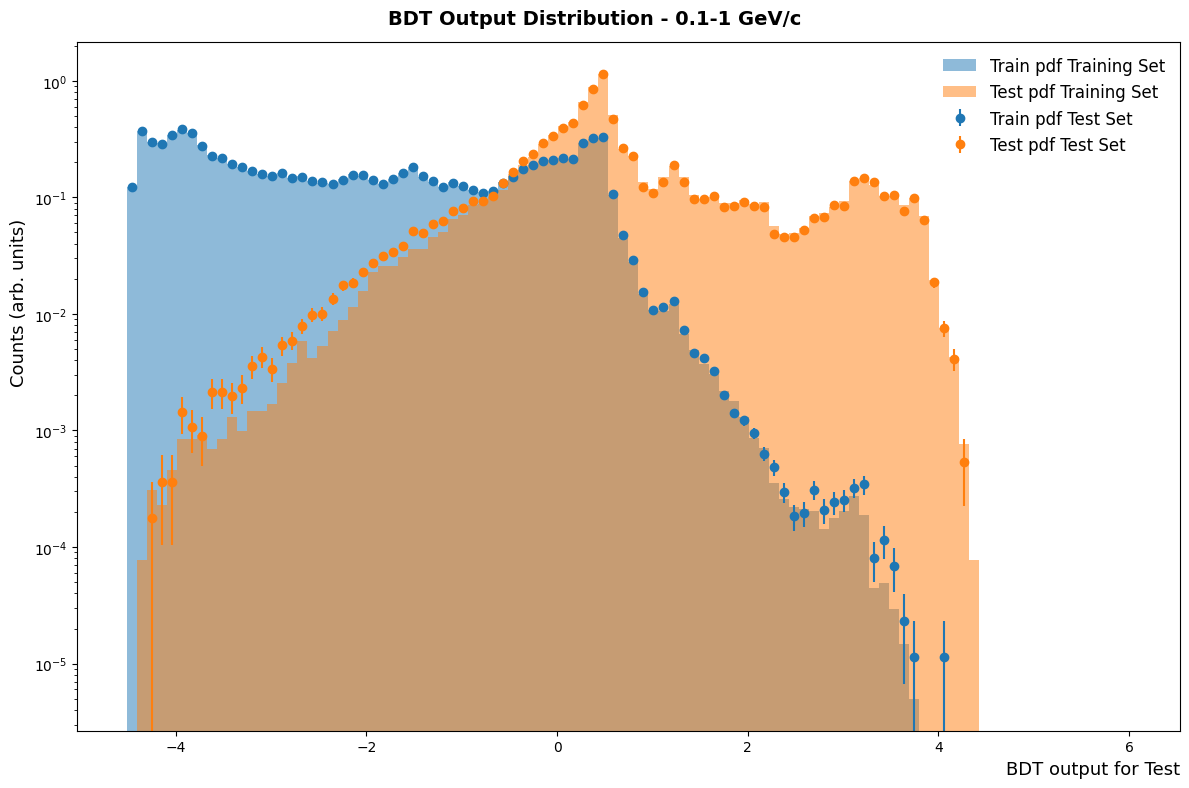

  ✓ BDT output plot created

  Generating ROC curves...


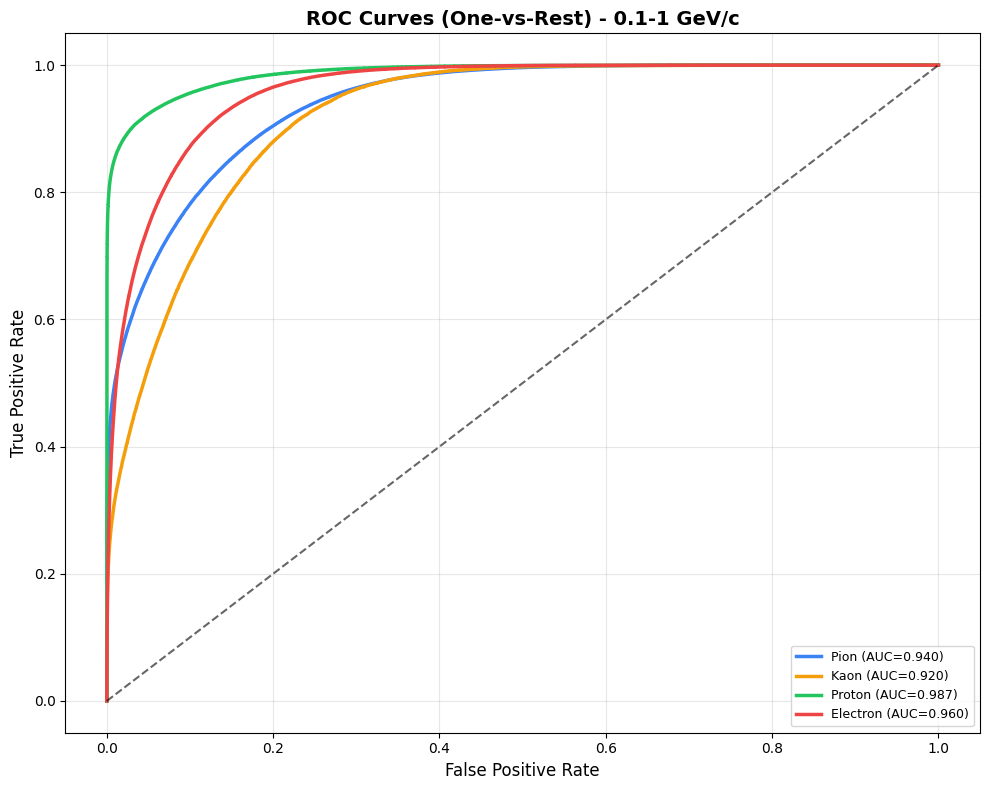

  ✓ ROC curves created

  Generating confusion matrix...


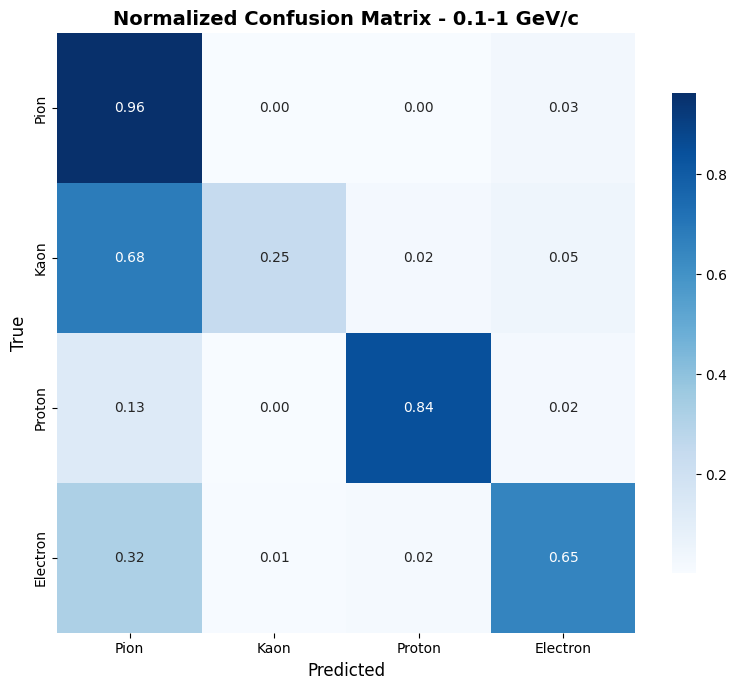

  ✓ Confusion matrix created

  Generating feature importance...


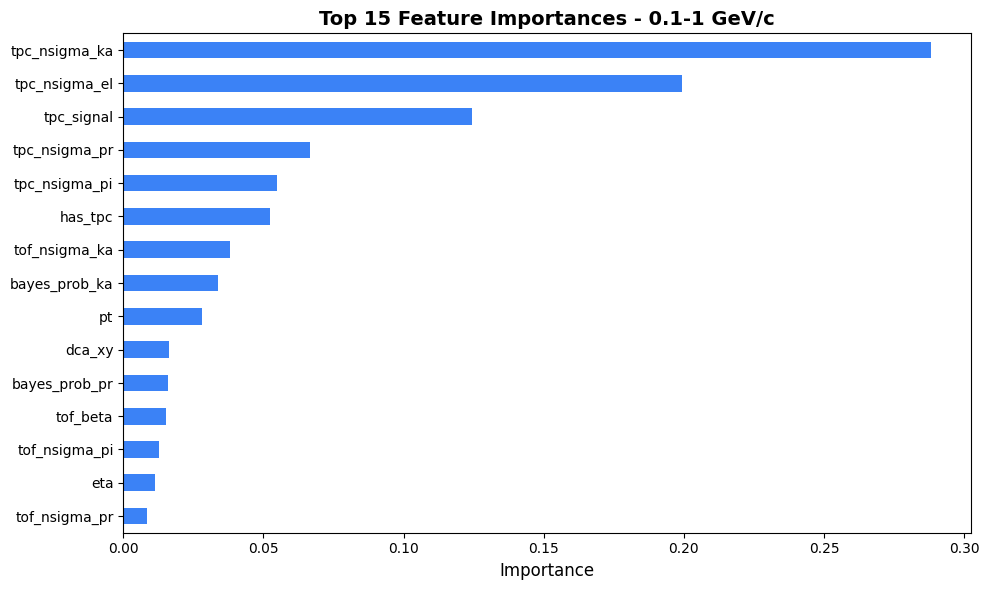

  ✓ Feature importance plot created

VISUALISATIONS: 1-3 GeV/c

  Generating BDT output distributions...


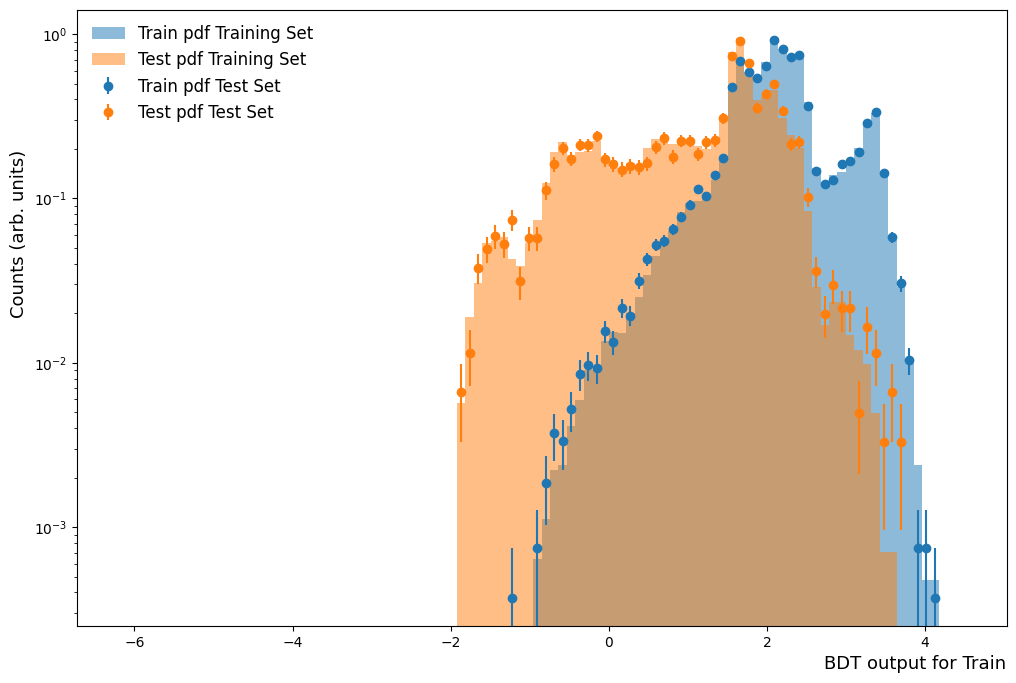

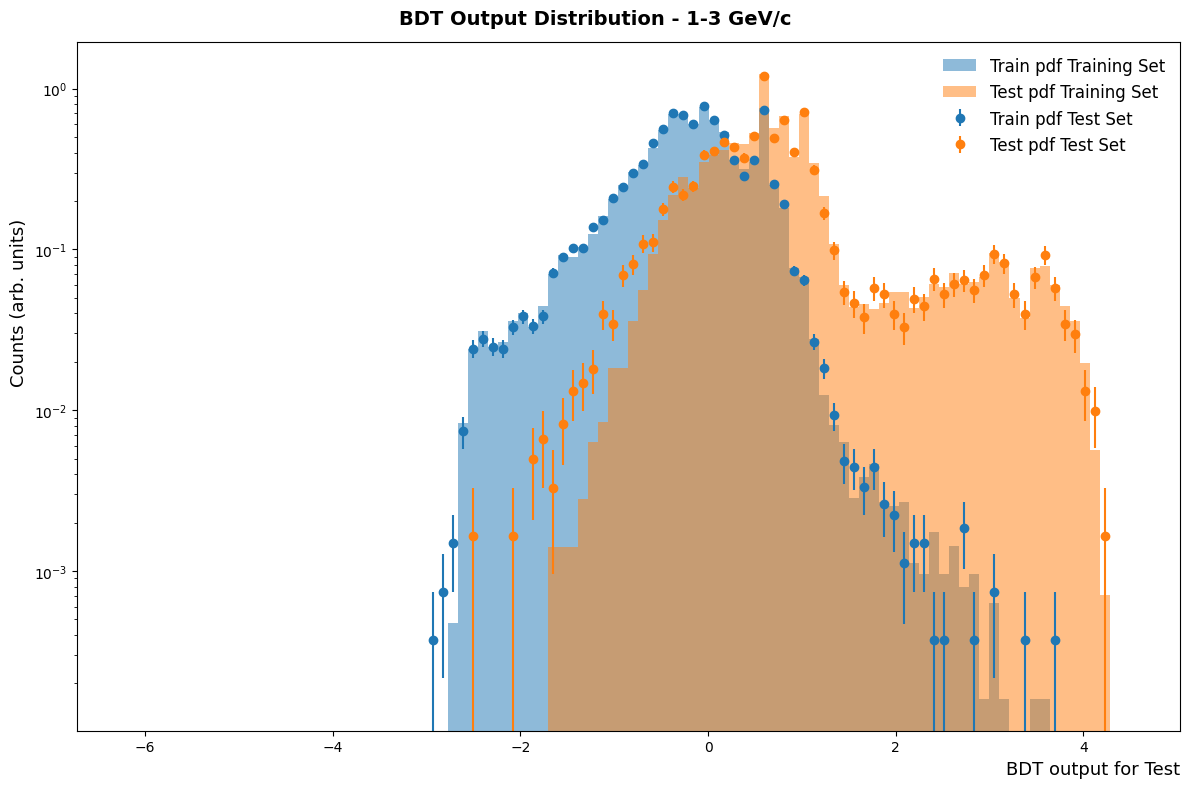

  ✓ BDT output plot created

  Generating ROC curves...


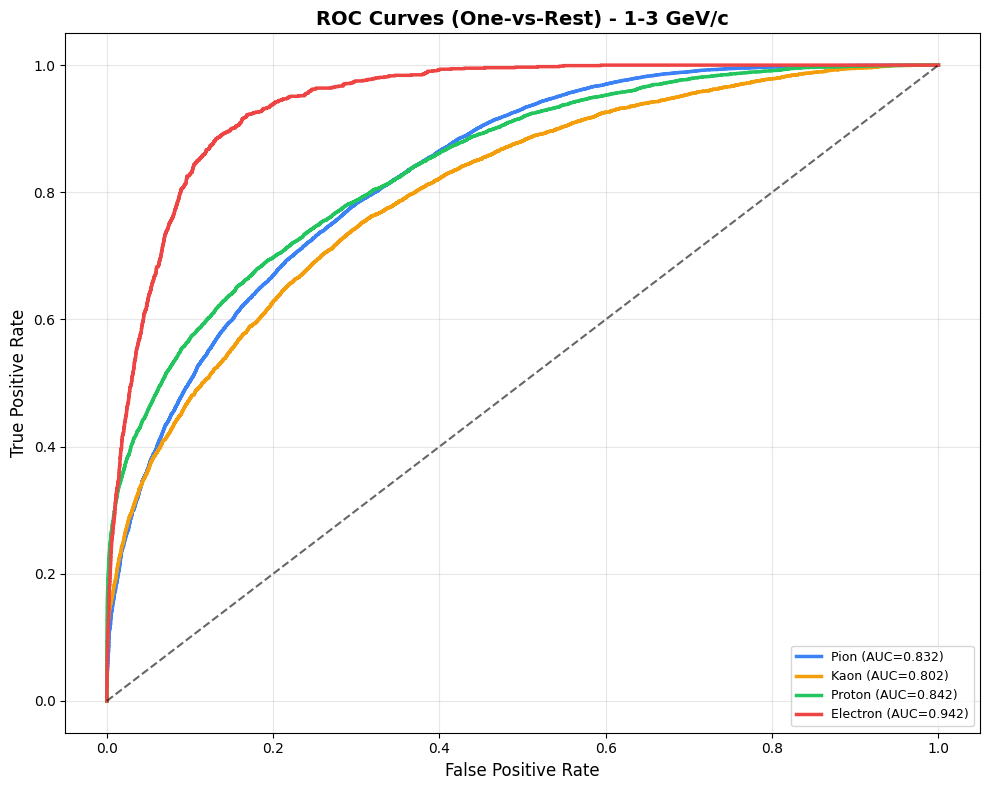

  ✓ ROC curves created

  Generating confusion matrix...


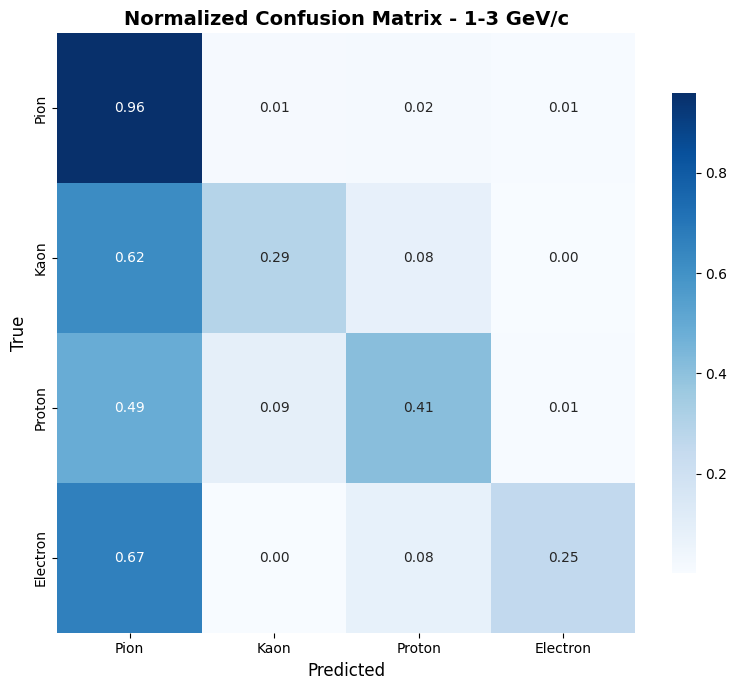

  ✓ Confusion matrix created

  Generating feature importance...


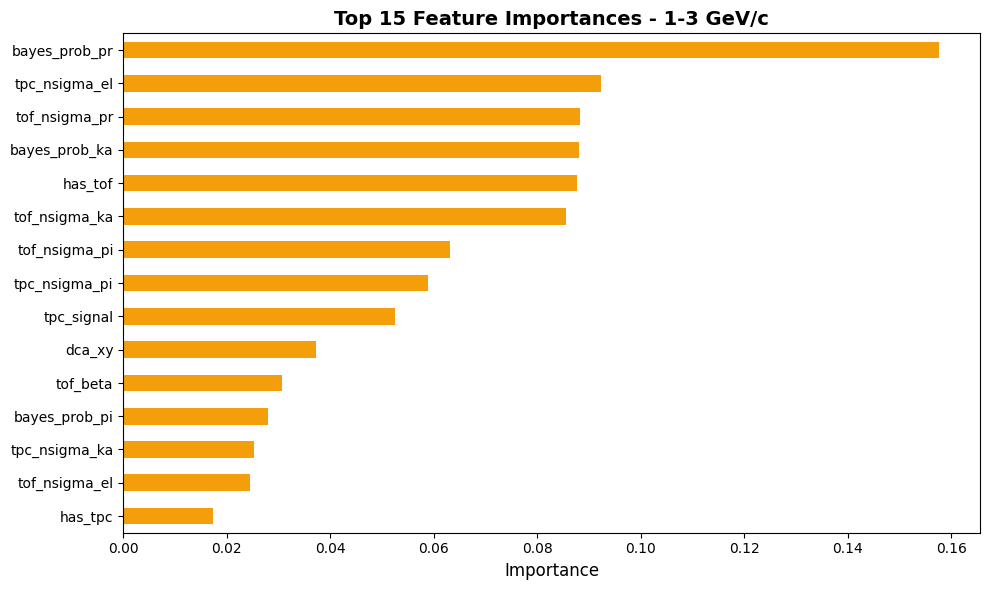

  ✓ Feature importance plot created

VISUALISATIONS: 3+ GeV/c

  Generating BDT output distributions...


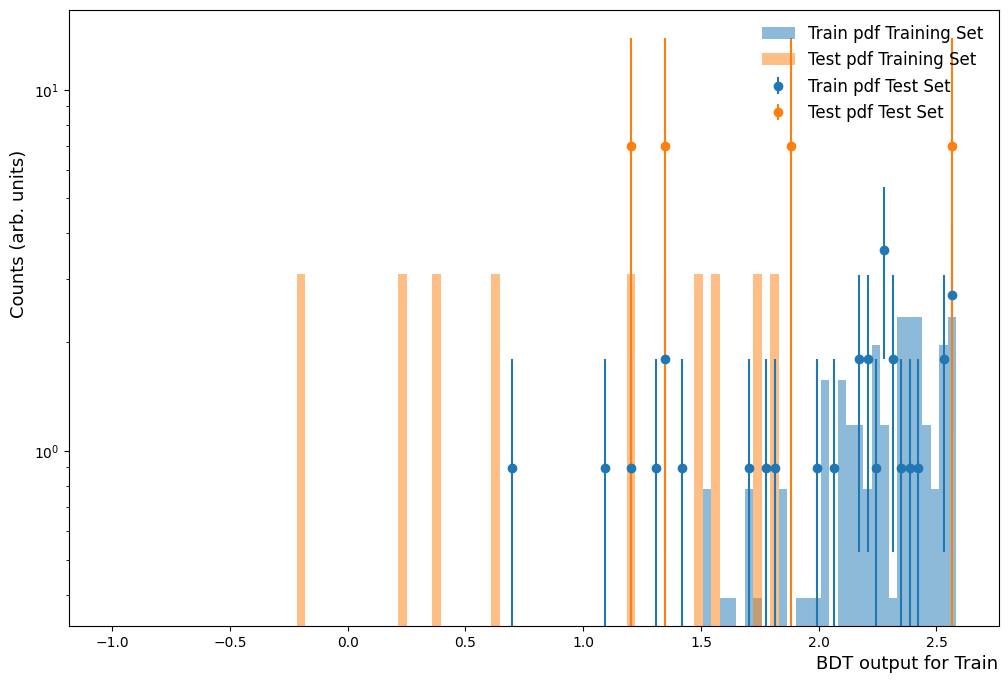

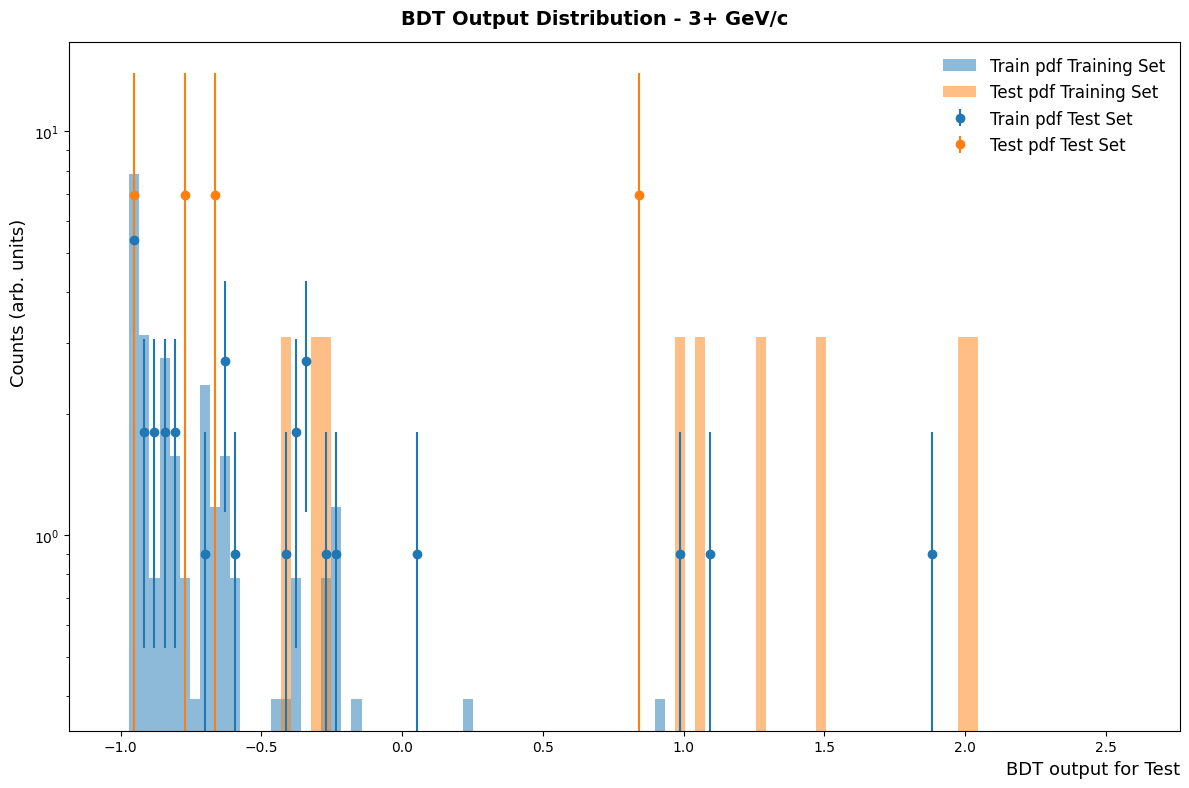

  ✓ BDT output plot created

  Generating ROC curves...


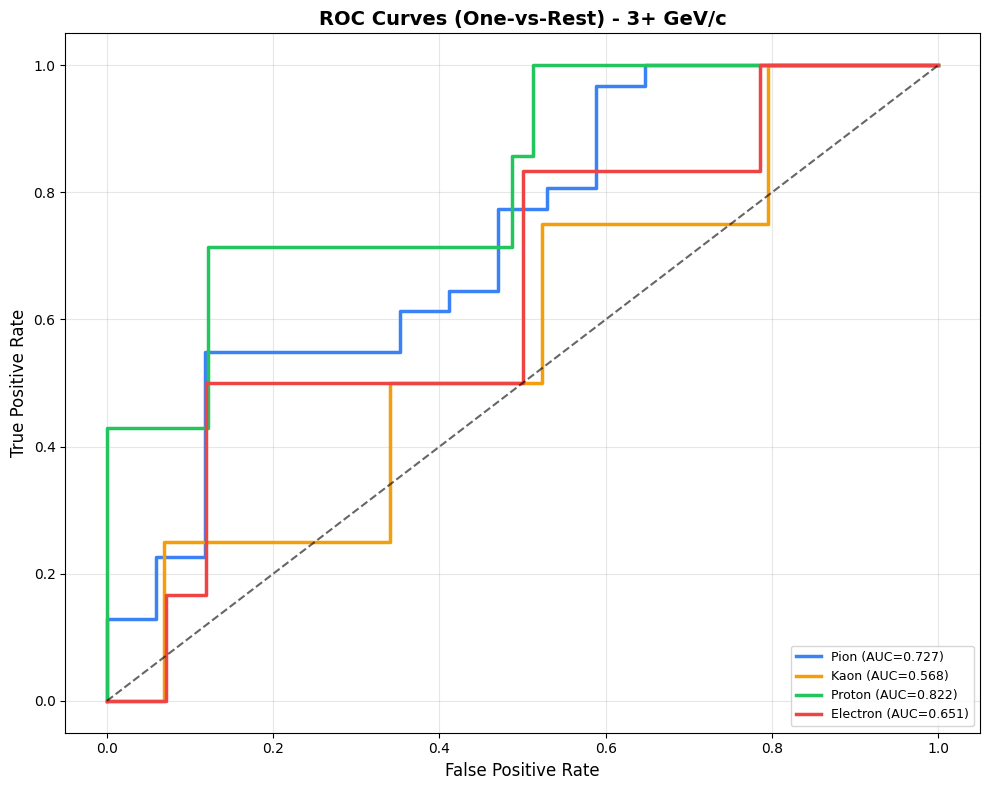

  ✓ ROC curves created

  Generating confusion matrix...


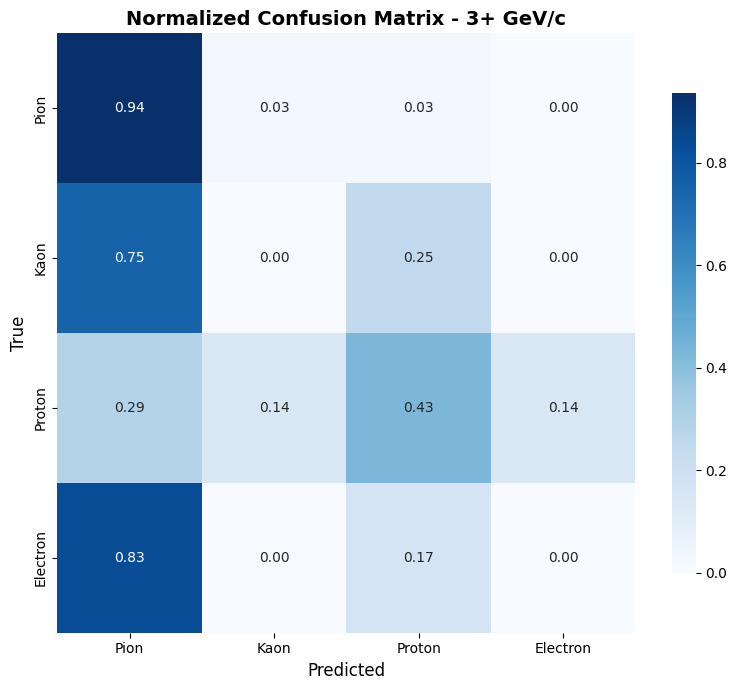

  ✓ Confusion matrix created

  Generating feature importance...


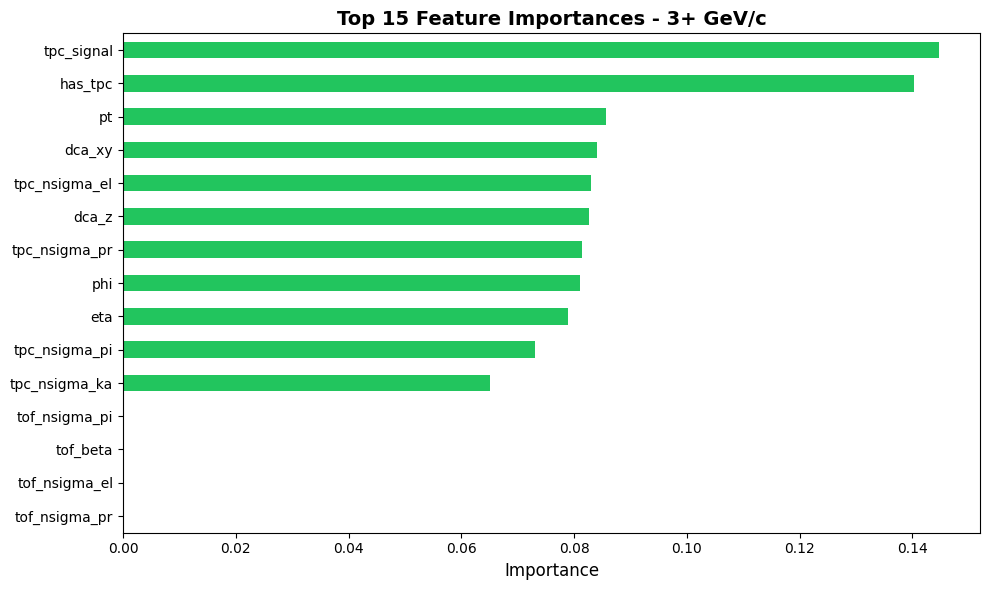

  ✓ Feature importance plot created

✓ All visualizations complete


In [14]:
print("\n" + "="*80)
print("SECTION 8: MODEL VISUALISATION & ANALYSIS")
print("="*80)

for range_key in ['full', 'low', 'mid', 'high']:
    if range_key not in trained_models:
        continue

    model_info = trained_models[range_key]
    dataset = momentum_datasets[range_key]
    range_name = model_info['config']['name']

    print(f"\n{'='*70}")
    print(f"VISUALISATIONS: {range_name}")
    print(f"{'='*70}")

    X_train_plot = dataset['X_train'].reset_index(drop=True)
    y_train_plot = dataset['y_train'].reset_index(drop=True)
    X_test_plot = dataset['X_test'].reset_index(drop=True)
    y_test_plot = dataset['y_test'].reset_index(drop=True)

    # 1. BDT OUTPUT DISTRIBUTIONS
    print("\n  Generating BDT output distributions...")
    plt.rcParams['figure.figsize'] = (12, 8)
    plot_utils.plot_output_train_test(
        model_info['model_handler'],
        [X_train_plot, y_train_plot, X_test_plot, y_test_plot],
        bins=100, density=True, logscale=True, labels=['Train', 'Test']
    )
    plt.suptitle(f'BDT Output Distribution - {range_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    print("  ✓ BDT output plot created")

    # 2. ROC CURVES
    print("\n  Generating ROC curves...")
    y_true = y_test_plot.values
    y_pred_prob = model_info['y_pred_proba']
    unique_classes = np.unique(y_true)
    colors_roc = cycle(['#3B82F6', '#F59E0B', '#22C55E', '#EF4444', '#8B5CF6'])

    plt.figure(figsize=(10, 8))
    for cls, color in zip(unique_classes, colors_roc):
        y_bin = (y_true == cls).astype(int)
        fpr, tpr, _ = roc_curve(y_bin, y_pred_prob[:, cls])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2.5, color=color, label=f"{PARTICLE_NAMES[cls]} (AUC={roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.6)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves (One-vs-Rest) - {range_name}', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=9)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    print("  ✓ ROC curves created")

    # 3. CONFUSION MATRIX
    print("\n  Generating confusion matrix...")
    y_pred_labels = np.argmax(y_pred_prob, axis=1)
    cm = confusion_matrix(y_true, y_pred_labels, normalize='true')

    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=[PARTICLE_NAMES[i] for i in unique_classes],
                yticklabels=[PARTICLE_NAMES[i] for i in unique_classes],
                cbar_kws={'shrink': 0.8})
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.title(f'Normalized Confusion Matrix - {range_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    print("  ✓ Confusion matrix created")

    # 4. FEATURE IMPORTANCE
    print("\n  Generating feature importance...")
    fi = pd.Series(
        model_info['model_handler'].model.feature_importances_,
        index=available_features
    ).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    fi.head(15).plot(kind='barh', color=model_info['config']['color'])
    plt.xlabel('Importance', fontsize=12)
    plt.title(f'Top 15 Feature Importances - {range_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    print("  ✓ Feature importance plot created")

print("\n✓ All visualizations complete")

## SECTION 9: Calculate PID Efficiency & Purity Metrics
### Quantify Particle Identification Performance

Metrics calculated for each particle in each range:
- **Efficiency (Recall)**: How many true particles are correctly identified? TP / (TP + FN)
- **Purity (Precision)**: How many identified particles are correct? TP / (TP + FP)
- **Contamination**: What fraction of identified particles are wrong? FP / (TP + FP)

In [15]:
print("\n" + "="*80)
print("SECTION 9: PID EFFICIENCY & PURITY METRICS")
print("="*80)

def calc_metrics(y_true, y_pred_prob, idx):
    """Calculate PID metrics (efficiency, purity, contamination)."""
    y_pred_labels = np.argmax(y_pred_prob, axis=1)
    y_true_bin = (y_true == idx).astype(int)
    y_pred_bin = (y_pred_labels == idx).astype(int)

    tp = np.sum((y_true_bin == 1) & (y_pred_bin == 1))  # True Positive
    fp = np.sum((y_true_bin == 0) & (y_pred_bin == 1))  # False Positive
    fn = np.sum((y_true_bin == 1) & (y_pred_bin == 0))  # False Negative

    efficiency = tp / (tp + fn) if (tp + fn) > 0 else 0
    purity = tp / (tp + fp) if (tp + fp) > 0 else 0
    contamination = fp / (tp + fp) if (tp + fp) > 0 else 0

    return {
        'efficiency': efficiency,
        'purity': purity,
        'contamination': contamination,
        'tp': tp, 'fp': fp, 'fn': fn
    }

pid_metrics_all = {}

print("\nCalculating metrics for all momentum ranges and particle species...\n")

for range_key in momentum_datasets.keys():
    if range_key not in trained_models:
        continue

    model_info = trained_models[range_key]
    dataset = momentum_datasets[range_key]
    range_name = model_info['config']['name']

    print(f"{'='*60}")
    print(f"{range_name}")
    print(f"{'='*60}")

    y_true = dataset['y_test'].values
    y_pred_prob = model_info['y_pred_proba']
    pid_metrics_all[range_key] = {}

    for i, particle in enumerate(PARTICLE_NAMES):
        metrics = calc_metrics(y_true, y_pred_prob, i)
        pid_metrics_all[range_key][particle] = metrics

        print(f"\n{particle:12s}:")
        print(f"  Efficiency:    {metrics['efficiency']:.4f} ({metrics['efficiency']*100:5.2f}%)")
        print(f"  Purity:        {metrics['purity']:.4f} ({metrics['purity']*100:5.2f}%)")
        print(f"  Contamination: {metrics['contamination']:.4f} ({metrics['contamination']*100:5.2f}%)")
        print(f"  TP: {metrics['tp']:5d}  FP: {metrics['fp']:5d}  FN: {metrics['fn']:5d}")

print("\n" + "="*80)
print("✓ PID metrics calculation complete")
print("="*80)


SECTION 9: PID EFFICIENCY & PURITY METRICS

Calculating metrics for all momentum ranges and particle species...

All Data (full spectrum)

Pion        :
  Efficiency:    0.9599 (95.99%)
  Purity:        0.8755 (87.55%)
  Contamination: 0.1245 (12.45%)
  TP: 829260  FP: 117961  FN: 34610

Kaon        :
  Efficiency:    0.2474 (24.74%)
  Purity:        0.7476 (74.76%)
  Contamination: 0.2524 (25.24%)
  TP: 14668  FP:  4952  FN: 44619

Proton      :
  Efficiency:    0.8238 (82.38%)
  Purity:        0.9329 (93.29%)
  Contamination: 0.0671 ( 6.71%)
  TP: 127971  FP:  9198  FN: 27372

Electron    :
  Efficiency:    0.6548 (65.48%)
  Purity:        0.7698 (76.98%)
  Contamination: 0.2302 (23.02%)
  TP: 111761  FP: 33416  FN: 58926
0.1-1 GeV/c

Pion        :
  Efficiency:    0.9623 (96.23%)
  Purity:        0.8817 (88.17%)
  Contamination: 0.1183 (11.83%)
  TP: 795206  FP: 106680  FN: 31183

Kaon        :
  Efficiency:    0.2451 (24.51%)
  Purity:        0.7692 (76.92%)
  Contamination: 0.230

## SECTION 10: Interactive Comparison Dashboard
### Explore PID Performance Across Momentum Ranges

**Interactive Tools:**
- Select any particle (Pion, Kaon, Proton, Electron, Deuteron)
- Choose any metric (Efficiency, Purity, Contamination)
- View as Bar Chart, Table, or ROC Curve comparison
- Visualise how performance changes with momentum

In [19]:
def plot_comp(particle, metric):
    """Plot metric comparison across momentum ranges as bar chart."""
    ranges = list(momentum_datasets.keys())
    values = [pid_metrics_all[r][particle][metric] for r in ranges]
    colors = [MOMENTUM_RANGES[r]['color'] for r in ranges]
    labels = [MOMENTUM_RANGES[r]['name'] for r in ranges]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(labels, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

    for bar, val in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
                f'{val:.3f}\n({val*100:.1f}%)',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.ylabel(metric.capitalize(), fontsize=13, fontweight='bold')
    plt.xlabel('Momentum Range', fontsize=13, fontweight='bold')
    plt.title(f'{metric.capitalize()} for {particle} Across Momentum Ranges',
              fontsize=14, fontweight='bold', pad=20)  # Added pad=20 for more space
    plt.xticks(rotation=15, ha='right')
    plt.grid(axis='y', alpha=0.3, linestyle='--')

    # Adjust y-axis limit to give more headroom for labels
    max_value = max(values)
    plt.ylim(0, max_value * 1.15)  # Add 15% extra space at the top

    plt.tight_layout()
    plt.show()


def show_table(particle):
    """Display comparison table for a particle."""
    ranges = list(momentum_datasets.keys())
    data = []
    for r in ranges:
        m = pid_metrics_all[r][particle]
        data.append({
            'Momentum Range': MOMENTUM_RANGES[r]['name'],
            'Efficiency': f"{m['efficiency']:.3f}",
            'Purity': f"{m['purity']:.3f}",
            'TP': m['tp'],
            'FP': m['fp']
        })
    df_t = pd.DataFrame(data)
    print(f"\n{'='*100}")
    print(f"Detailed Metrics: {particle.upper()}")
    print(f"{'='*100}\n")
    print(df_t.to_string(index=False))
    print()


def plot_roc_comp(particle):
    """Plot ROC curves for same particle across all momentum ranges."""
    idx = PARTICLE_NAMES.index(particle)

    plt.figure(figsize=(10, 8))

    for range_key in momentum_datasets.keys():
        if range_key not in trained_models:
            continue

        model_info = trained_models[range_key]
        dataset = momentum_datasets[range_key]

        y_true = dataset['y_test'].values
        y_pred = model_info['y_pred_proba']
        y_bin = (y_true == idx).astype(int)
        fpr, tpr, _ = roc_curve(y_bin, y_pred[:, idx])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, color=MOMENTUM_RANGES[range_key]['color'], lw=3,
                label=f"{MOMENTUM_RANGES[range_key]['name']} (AUC={roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
    plt.title(f'ROC Curves for {particle} Across Momentum Ranges',
              fontsize=14, fontweight='bold', pad=20)  # Added pad=20 for more space
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


print("\n" + "="*80)
print("SECTION 10: INTERACTIVE COMPARISON DASHBOARD")
print("="*80)
print("\n Use the controls below to explore PID performance:\n")


# Create interactive widgets
particle_dd = widgets.Dropdown(
    options=PARTICLE_NAMES, value='Pion',
    description='Select Particle:', style={'description_width': '150px'}
)
metric_dd = widgets.Dropdown(
    options=['efficiency', 'purity', 'contamination'],
    value='efficiency',
    description='Select Metric:', style={'description_width': '150px'}
)
plot_type = widgets.RadioButtons(
    options=['Bar Chart', 'Comparison Table', 'ROC Curves'],
    value='Bar Chart',
    description='Visualization Type:', style={'description_width': '150px'}
)


output = widgets.Output()


def update(change=None):
    """Update visualization when controls change."""
    with output:
        clear_output(wait=True)

        particle = particle_dd.value
        metric = metric_dd.value
        viz_type = plot_type.value

        if viz_type == 'Bar Chart':
            plot_comp(particle, metric)
        elif viz_type == 'Comparison Table':
            show_table(particle)
        else:  # ROC Curves
            plot_roc_comp(particle)


# Attach event listeners
particle_dd.observe(update, names='value')
metric_dd.observe(update, names='value')
plot_type.observe(update, names='value')


# Create UI layout
title = widgets.HTML("<h3>PID Performance Comparison Across Momentum Ranges</h3>")
controls = widgets.VBox([particle_dd, metric_dd, plot_type])
ui = widgets.VBox([title, controls, output])


# Initial plot
with output:
    plot_comp('Pion', 'efficiency')


# Display dashboard
display(ui)
print("✓ Interactive dashboard ready!")



SECTION 10: INTERACTIVE COMPARISON DASHBOARD

 Use the controls below to explore PID performance:



✓ Interactive dashboard ready!


## SECTION 11: Final Summary
### Analysis Results & Conclusions

This section provides a final summary of:
- All trained models and their accuracies
- Performance across momentum ranges
- Key findings for each particle species

In [17]:
print("\n" + "="*80)
print("SECTION 11: FINAL ANALYSIS SUMMARY")
print("="*80)

print(f"\n✓ ANALYSIS COMPLETE\n")
print(f"Successfully analysed {len(trained_models)} momentum ranges:\n")

summary_data = []
for range_key, model_info in trained_models.items():
    config = model_info['config']
    summary_data.append({
        'Momentum Range': config['name'],
        'Train Accuracy': f"{model_info['train_acc']:.4f}",
        'Test Accuracy': f"{model_info['test_acc']:.4f}",
        'Models Trained': 'XGBoost'
    })
    print(f"  • {config['name']:30s}")
    print(f"    Train Accuracy: {model_info['train_acc']:.4f}")
    print(f"    Test Accuracy:  {model_info['test_acc']:.4f}")
    print()

print("\n" + "="*80)
print("KEY METRICS")
print("="*80)

for particle in PARTICLE_NAMES:
    print(f"\n{particle}:")
    for range_key in momentum_datasets.keys():
        if range_key in pid_metrics_all and particle in pid_metrics_all[range_key]:
            metrics = pid_metrics_all[range_key][particle]
            range_name = MOMENTUM_RANGES[range_key]['name']
            print(f"  {range_name:30s} - Eff: {metrics['efficiency']:.3f}, Pur: {metrics['purity']:.3f}")

print("\n" + "="*80)
print("✓ Notebook execution complete!")
print("="*80)


SECTION 11: FINAL ANALYSIS SUMMARY

✓ ANALYSIS COMPLETE

Successfully analysed 4 momentum ranges:

  • All Data (full spectrum)      
    Train Accuracy: 0.8705
    Test Accuracy:  0.8675

  • 0.1-1 GeV/c                   
    Train Accuracy: 0.8769
    Test Accuracy:  0.8741

  • 1-3 GeV/c                     
    Train Accuracy: 0.7554
    Test Accuracy:  0.7470

  • 3+ GeV/c                      
    Train Accuracy: 0.8899
    Test Accuracy:  0.6667


KEY METRICS

Pion:
  All Data (full spectrum)       - Eff: 0.960, Pur: 0.875
  0.1-1 GeV/c                    - Eff: 0.962, Pur: 0.882
  1-3 GeV/c                      - Eff: 0.958, Pur: 0.764
  3+ GeV/c                       - Eff: 0.935, Pur: 0.744

Kaon:
  All Data (full spectrum)       - Eff: 0.247, Pur: 0.748
  0.1-1 GeV/c                    - Eff: 0.245, Pur: 0.769
  1-3 GeV/c                      - Eff: 0.292, Pur: 0.637
  3+ GeV/c                       - Eff: 0.000, Pur: 0.000

Proton:
  All Data (full spectrum)       - Eff: 